In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import warnings
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
from pooch import retrieve as download

# this makes sure we can import `gcb_ocean_python.validation_sfco2_socat`
sys.path.insert(0, '../gcb_ocean_python/')

# stop warnings from displaying when importing this package
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 150

# note that socat validation is a standalone package and can be copied around without 
# any other python files required (appart from dependencies)
import evaluation_sfco2_socat as gcb_eval
import viz  # allows us to quickly plot maps (not standalone)

/Users/luke/opt/miniconda3/lib/python3.9/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# The function's documentation

In [2]:
help(gcb_eval.evaluate_sfco2)

Help on function evaluate_sfco2 in module evaluation_sfco2_socat:

evaluate_sfco2(sfco2, region='all', method='annual', cache_dir='/Users/luke/Git/GCB-Ocean-scripts/data_cache/', log_level=20)
    Evaluates predicted sfco2 against SOCATv2022 sfCO2
    
    Note 
    ----
    You will have to apply a mask to the input yourself. 
    In GCB2022 the mask is the area that all data products cover, thus
    cannot be created or derived for each individual product
    
    Parameters
    ----------
    sfco2 : [np.ndarray, xr.DataArray]
        Must be a 3-dimensional array [time, lat, lon] with 
        lat = [-90, 90], lon = [-180, 180]. Assumed that time ends
        on 2021-12-15
    method : str, optional
        'monthly' or 'annual', by default 'annual'
    region : [int, str]
        choose from one of three regions. global=0, north=1, tropics=2, south=3, all=4
        can be a string or an integer value, by default 'all'
    cache_dir : path, optional
        The path to the cache wh

# Running the function

You'll notice that there are two methods: `annual` and `monthly`

The first is how GCB calculates RMSE, while the second is how Gregor et al. (2019) calculate RMSE. 

In [3]:
# the path to the zenodo repository
url = 'https://zenodo.org/record/7273309/files/GCB-2022_dataprod_LDEO-HPD_1982-2021.nc?download=1'
fname = gcb_eval.download(url, dest_path='./data_cache/')
sfco2 = xr.open_dataset(fname).sfco2

In [4]:
rmse_annual = gcb_eval.evaluate_sfco2(sfco2, region='all', method='annual', log_level=20)

[GCB-2022-eval] Converted inputs to xr.DataArray based on shape
[GCB-2022-eval] sfco2 is within expected range [0, 1000] - [233.3, 473.33]. 
[GCB-2022-eval] Comparing sfco2 against SOCATv2022 for region GLOBAL
[GCB-2022-eval] Calculating statistics for region: GLOBAL
[GCB-2022-eval] Converted inputs to xr.DataArray based on shape
[GCB-2022-eval] Using annual RMSE method fco2[time, lat, lon] --> mean(lat, lon) -> annual_mean -> detrend -> (fco2 - socat) -> square(resid) -> mean -> sqrt
[GCB-2022-eval] Comparing sfco2 against SOCATv2022 for region NORTH
[GCB-2022-eval] Calculating statistics for region: NORTH
[GCB-2022-eval] Converted inputs to xr.DataArray based on shape
[GCB-2022-eval] Using annual RMSE method fco2[time, lat, lon] --> mean(lat, lon) -> annual_mean -> detrend -> (fco2 - socat) -> square(resid) -> mean -> sqrt
[GCB-2022-eval] Comparing sfco2 against SOCATv2022 for region TROPICS
[GCB-2022-eval] Calculating statistics for region: TROPICS
[GCB-2022-eval] Converted inputs t

In [5]:
rmse_annual

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, time: 480, region: 4, year: 40)
Coordinates:
  * time          (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2021-12-15
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * region        (region) object 'global' 'north' 'tropics' 'south'
  * year          (year) int64 1982 1983 1984 1985 1986 ... 2018 2019 2020 2021
Data variables:
    mask          (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    sfco2_socat   (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    sfco2_input   (time, lat, lon) float64 nan nan nan nan ... 335.6 335.2 334.7
    diff_annual   (region, year) float64 -0.8706 -0.5492 ... 0.5638 0.06136
    count_annual  (region, year) float64 470.0 490.0 ... 2.11e+03 1.015e+03
    bias          (region) float64 -1.251e-13 7.589e-13 -8.455e-13 2.019e-13
    rmse          (region) float64 0.7968 1.159 0.6115 2.723

In [6]:
# log_level=10 is is very verbose; default is 20; for quiet operation, set to 30
rmse_monthly = gcb_eval.evaluate_sfco2(sfco2, region='all', method='monthly', log_level=30) 

# Difference between the two methods

### Annual approach

1. subsample data points for where there are obs (automatically done)
2. average over lon and lat
1. calculate annual mean
1. take out any point where model or data are NaNs (no need)
1. detrend both time-series (model, socat)
1. calculate rmse (using square root of the averaged square of residuals)

### Monthly approach

1. difference between the model and target data = residuals
1. square the resudials
1. average over lat and lon
1. resample to annual mean
1. square root of the annual mean
1. average over time (years)

## Summary
The main difference is that ANNUAL comparse aggregated time series, while MONTHLY compares individual points and then aggregates

<AxesSubplot:xlabel='region'>

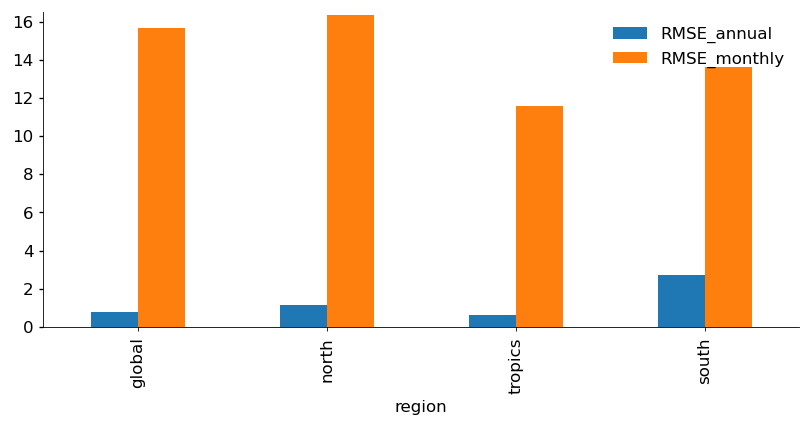

In [7]:
rmse = pd.concat([
    rmse_annual.rmse.to_series().rename('RMSE_annual'),
    rmse_monthly.rmse.to_series().rename('RMSE_monthly'),
], axis=1)

fig, ax = plt.subplots(figsize=[7,3])
rmse.plot.bar(ax=ax)

# Running with model data

In [8]:
url = "https://zenodo.org/record/7273309/files/GCB-2022_OceanModel_Princeton_1959-2021.nc?download=1"
fname = download(url, None, fname='GCB-2022_OceanModel_Princeton_1959-2021.nc', path='./data_cache/')
sfco2 = xr.open_dataset(fname).sfco2.sel(simulation='A')

In [10]:
model_rmse = gcb_eval.evaluate_sfco2(sfco2, region='all', method='annual')

[GCB-2022-eval] Converted inputs to xr.DataArray based on shape
[GCB-2022-eval] sfco2 is within expected range [0, 1000] - [175.94, 490.86]. 
[GCB-2022-eval] Comparing sfco2 against SOCATv2022 for region GLOBAL
[GCB-2022-eval] Calculating statistics for region: GLOBAL
[GCB-2022-eval] Converted inputs to xr.DataArray based on shape
[GCB-2022-eval] Using annual RMSE method fco2[time, lat, lon] --> mean(lat, lon) -> annual_mean -> detrend -> (fco2 - socat) -> square(resid) -> mean -> sqrt
[GCB-2022-eval] Comparing sfco2 against SOCATv2022 for region NORTH
[GCB-2022-eval] Calculating statistics for region: NORTH
[GCB-2022-eval] Converted inputs to xr.DataArray based on shape
[GCB-2022-eval] Using annual RMSE method fco2[time, lat, lon] --> mean(lat, lon) -> annual_mean -> detrend -> (fco2 - socat) -> square(resid) -> mean -> sqrt
[GCB-2022-eval] Comparing sfco2 against SOCATv2022 for region TROPICS
[GCB-2022-eval] Calculating statistics for region: TROPICS
[GCB-2022-eval] Converted inputs 

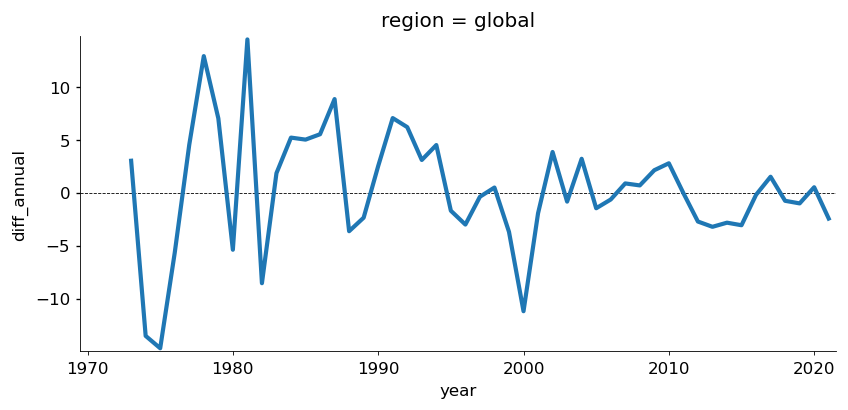

In [11]:
fig, ax = plt.subplots(figsize=[7,3])

ax.axhline(0, color='k', linestyle='--', lw=0.5)
model_rmse.diff_annual[0].plot(ax=ax)


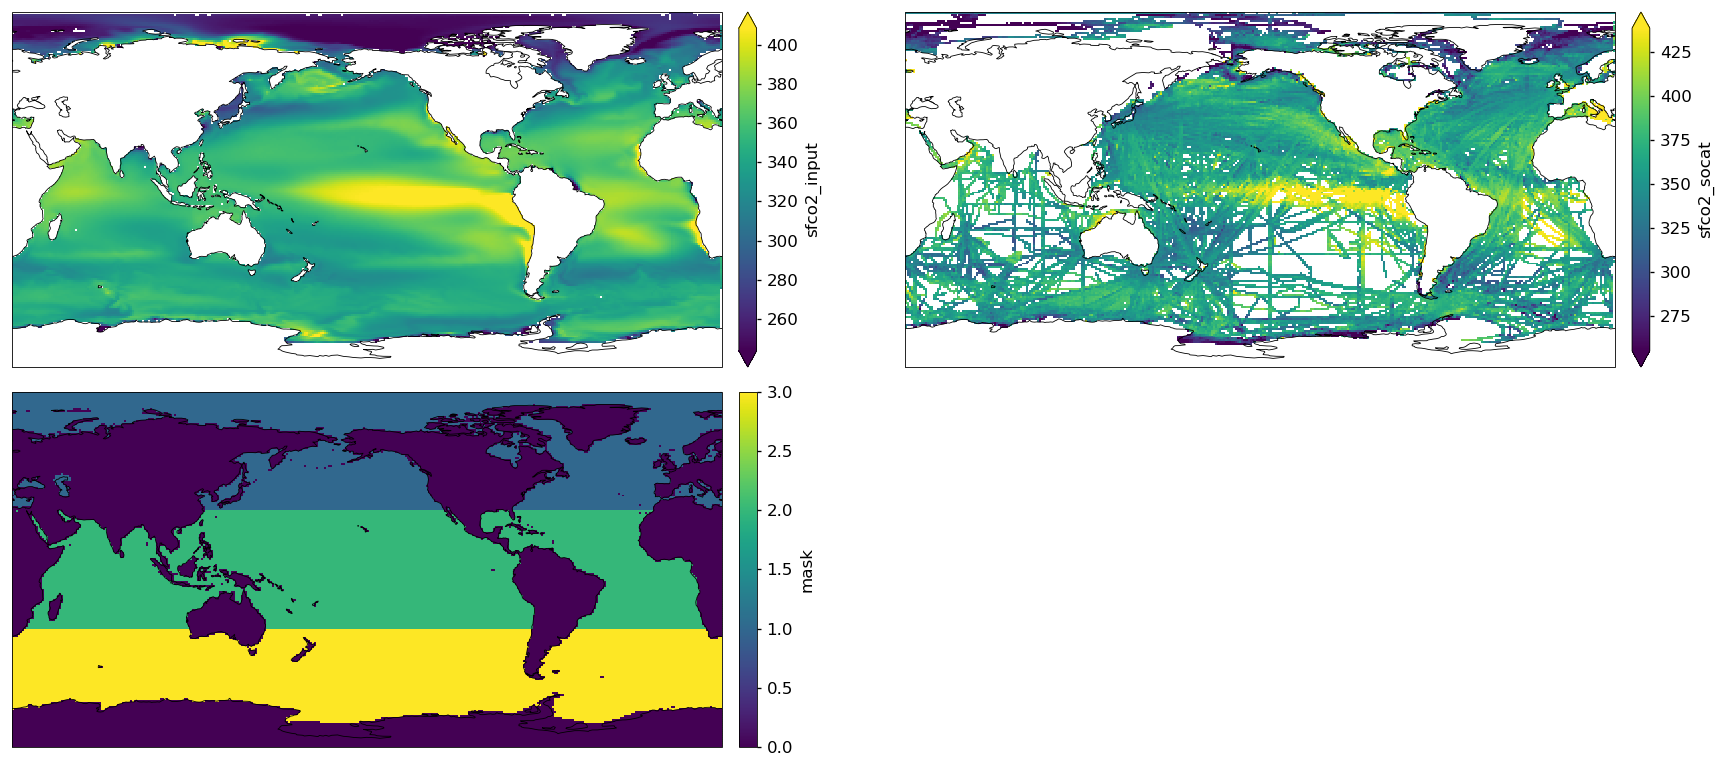

In [21]:
model_rmse.sfco2_input.mean('time').geo(pos=221)
model_rmse.sfco2_socat.mean('time').geo(pos=222)
model_rmse.mask.geo(pos=223)